# 02 - Beta Estimation & Import External Estimates

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
import numpy as np

#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#import linearmodels as lm

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import sys
sys.path.append('../')
sys.path.append('../../kungfu/')
import kungfu as kf

../../kungfu\kungfu\portfolio.py:175: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'simultaneous':
../../kungfu\kungfu\portfolio.py:177: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif method is 'sequential':
../../kungfu\kungfu\portfolio.py:224: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'percentage':
../../kungfu\kungfu\portfolio.py:228: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif method is 'fixed':
../../kungfu\kungfu\portfolio.py:726: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'continuous':
../../kungfu\kungfu\portfolio.py:728: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif method is 'discrete':
../../kungfu\kungfu\namespace.py:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if output is 'full':
../../kungfu\kungfu\namespace.py:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif output is 'index':
../../kungfu\kungfu\namespace.py:4

## Settings

In [4]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [5]:
%matplotlib inline

In [6]:
#sns.set()
#sns.set(rc={'figure.figsize': (17, 6)})

In [7]:
#plt.style.use('fivethirtyeight')
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [17, 8]
#plt.rcParams['figure.dpi'] = 80

## Load & prepare data
#### Previously saved

In [8]:
df_crsp_desc = pd.read_pickle('../data/raw/df_crsp_desc.pkl')

In [9]:
df_ff_raw = pd.read_pickle('../data/raw/df_ff_raw.pkl')
df_ff_raw['date'] = pd.to_datetime(df_ff_raw['date'], yearfirst=True)
df_ff_raw = df_ff_raw.set_index('date')

In [10]:
df_estimation = pd.read_pickle('../data/processed/df_estimation.pkl')

In [11]:
df_indices = pd.read_pickle('../data/processed/df_indices.pkl')

#### External estimates

In [12]:
df_in = pd.read_csv('../data/external/INnewSortings.csv', header=None)
df_out = pd.read_csv('../data/external/OUTnewSortings.csv', header=None)

In [13]:
df_in.columns = df_indices.columns
df_out.columns = df_indices.columns

estimate_index = pd.MultiIndex.from_arrays([df_indices.stack().values, df_indices.stack().index.get_level_values(1)])
df_estimates = pd.DataFrame(index=estimate_index)
df_estimates['in'] = df_in.stack().values
df_estimates['out'] = df_out.stack().values

## Estimate betas
### Define factor models

In [14]:
capm = kf.FactorModel(df_ff_raw['mktrf'])
ff3f = kf.FactorModel(df_ff_raw[['mktrf', 'smb', 'hml']])
c4f = kf.FactorModel(df_ff_raw[['mktrf', 'smb', 'hml', 'umd']])
models = [capm, ff3f, c4f]

### Estimate factor models

In [16]:
sample_years = df_estimates.index.get_level_values(1).unique()
for year in sample_years:
    # import data
    df_estimation = pd.read_csv('../data/processed/yearly/df_estimation_'+str(year)+'.csv')
    df_estimation['date'] = pd.to_datetime(df_estimation['date'], yearfirst=True)
    df_estimation = df_estimation.set_index('date')
    
    #capm
    coeff = capm.fit(df_estimation).estimates
    coeff.index = pd.MultiIndex.from_product([[int(i) for i in coeff.index],[year]])
    coeff.columns = ['capm_'+i for i in coeff.columns]
    for col in coeff.columns:
        df_estimates.loc[list(coeff.index),col] = coeff[col]
        
    #ff3f
    coeff = ff3f.fit(df_estimation).estimates
    coeff.index = pd.MultiIndex.from_product([[int(i) for i in coeff.index],[year]])
    coeff.columns = ['ff3f_'+i for i in coeff.columns]
    for col in coeff.columns:
        df_estimates.loc[list(coeff.index),col] = coeff[col]
        
    #c4f
    coeff = c4f.fit(df_estimation).estimates
    coeff.index = pd.MultiIndex.from_product([[int(i) for i in coeff.index],[year]])
    coeff.columns = ['c4f_'+i for i in coeff.columns]
    for col in coeff.columns:
        df_estimates.loc[list(coeff.index),col] = coeff[col]
    
    print(year)

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [17]:
df_estimates = df_estimates.astype(float)
df_estimates.to_pickle(path='../data/processed/df_estimates.pkl')

## Calculate returns & Volatility

In [18]:
for year in sample_years:
    # import data
    df_estimation = pd.read_csv('../data/processed/yearly/df_estimation_'+str(year)+'.csv')
    df_estimation['date'] = pd.to_datetime(df_estimation['date'], yearfirst=True)
    df_estimation = df_estimation.set_index('date')
    
    index = [(int(i), year) for i in df_estimation.columns]
    
    # returns
    df_estimates.loc[index,'ret1M'] = df_estimation.groupby(pd.Grouper(freq='M')).apply(lambda x: (x+1).prod()-1).tail(1).squeeze().values
    df_estimates.loc[index,'ret3M'] = df_estimation.groupby(pd.Grouper(freq='Q')).apply(lambda x: (x+1).prod()-1).tail(1).squeeze().values
    df_estimates.loc[index,'ret12M'] = df_estimation.groupby(pd.Grouper(freq='Y')).apply(lambda x: (x+1).prod()-1).tail(1).squeeze().values
    df_estimates.loc[index,'ret'] = ((df_estimation+1).prod()-1).values
    
    # volatility
    df_estimates.loc[index,'vola1M'] = df_estimation.groupby(pd.Grouper(freq='M')).std().tail(1).squeeze().values
    df_estimates.loc[index,'vola3M'] = df_estimation.groupby(pd.Grouper(freq='Q')).std().tail(1).squeeze().values
    df_estimates.loc[index,'vola12M'] = df_estimation.groupby(pd.Grouper(freq='Y')).std().tail(1).squeeze().values
    df_estimates.loc[index,'vola'] = df_estimation.std().values

In [19]:
df_estimates = df_estimates.astype(float)
df_estimates.to_pickle(path='../data/processed/df_estimates.pkl')

## Analysis

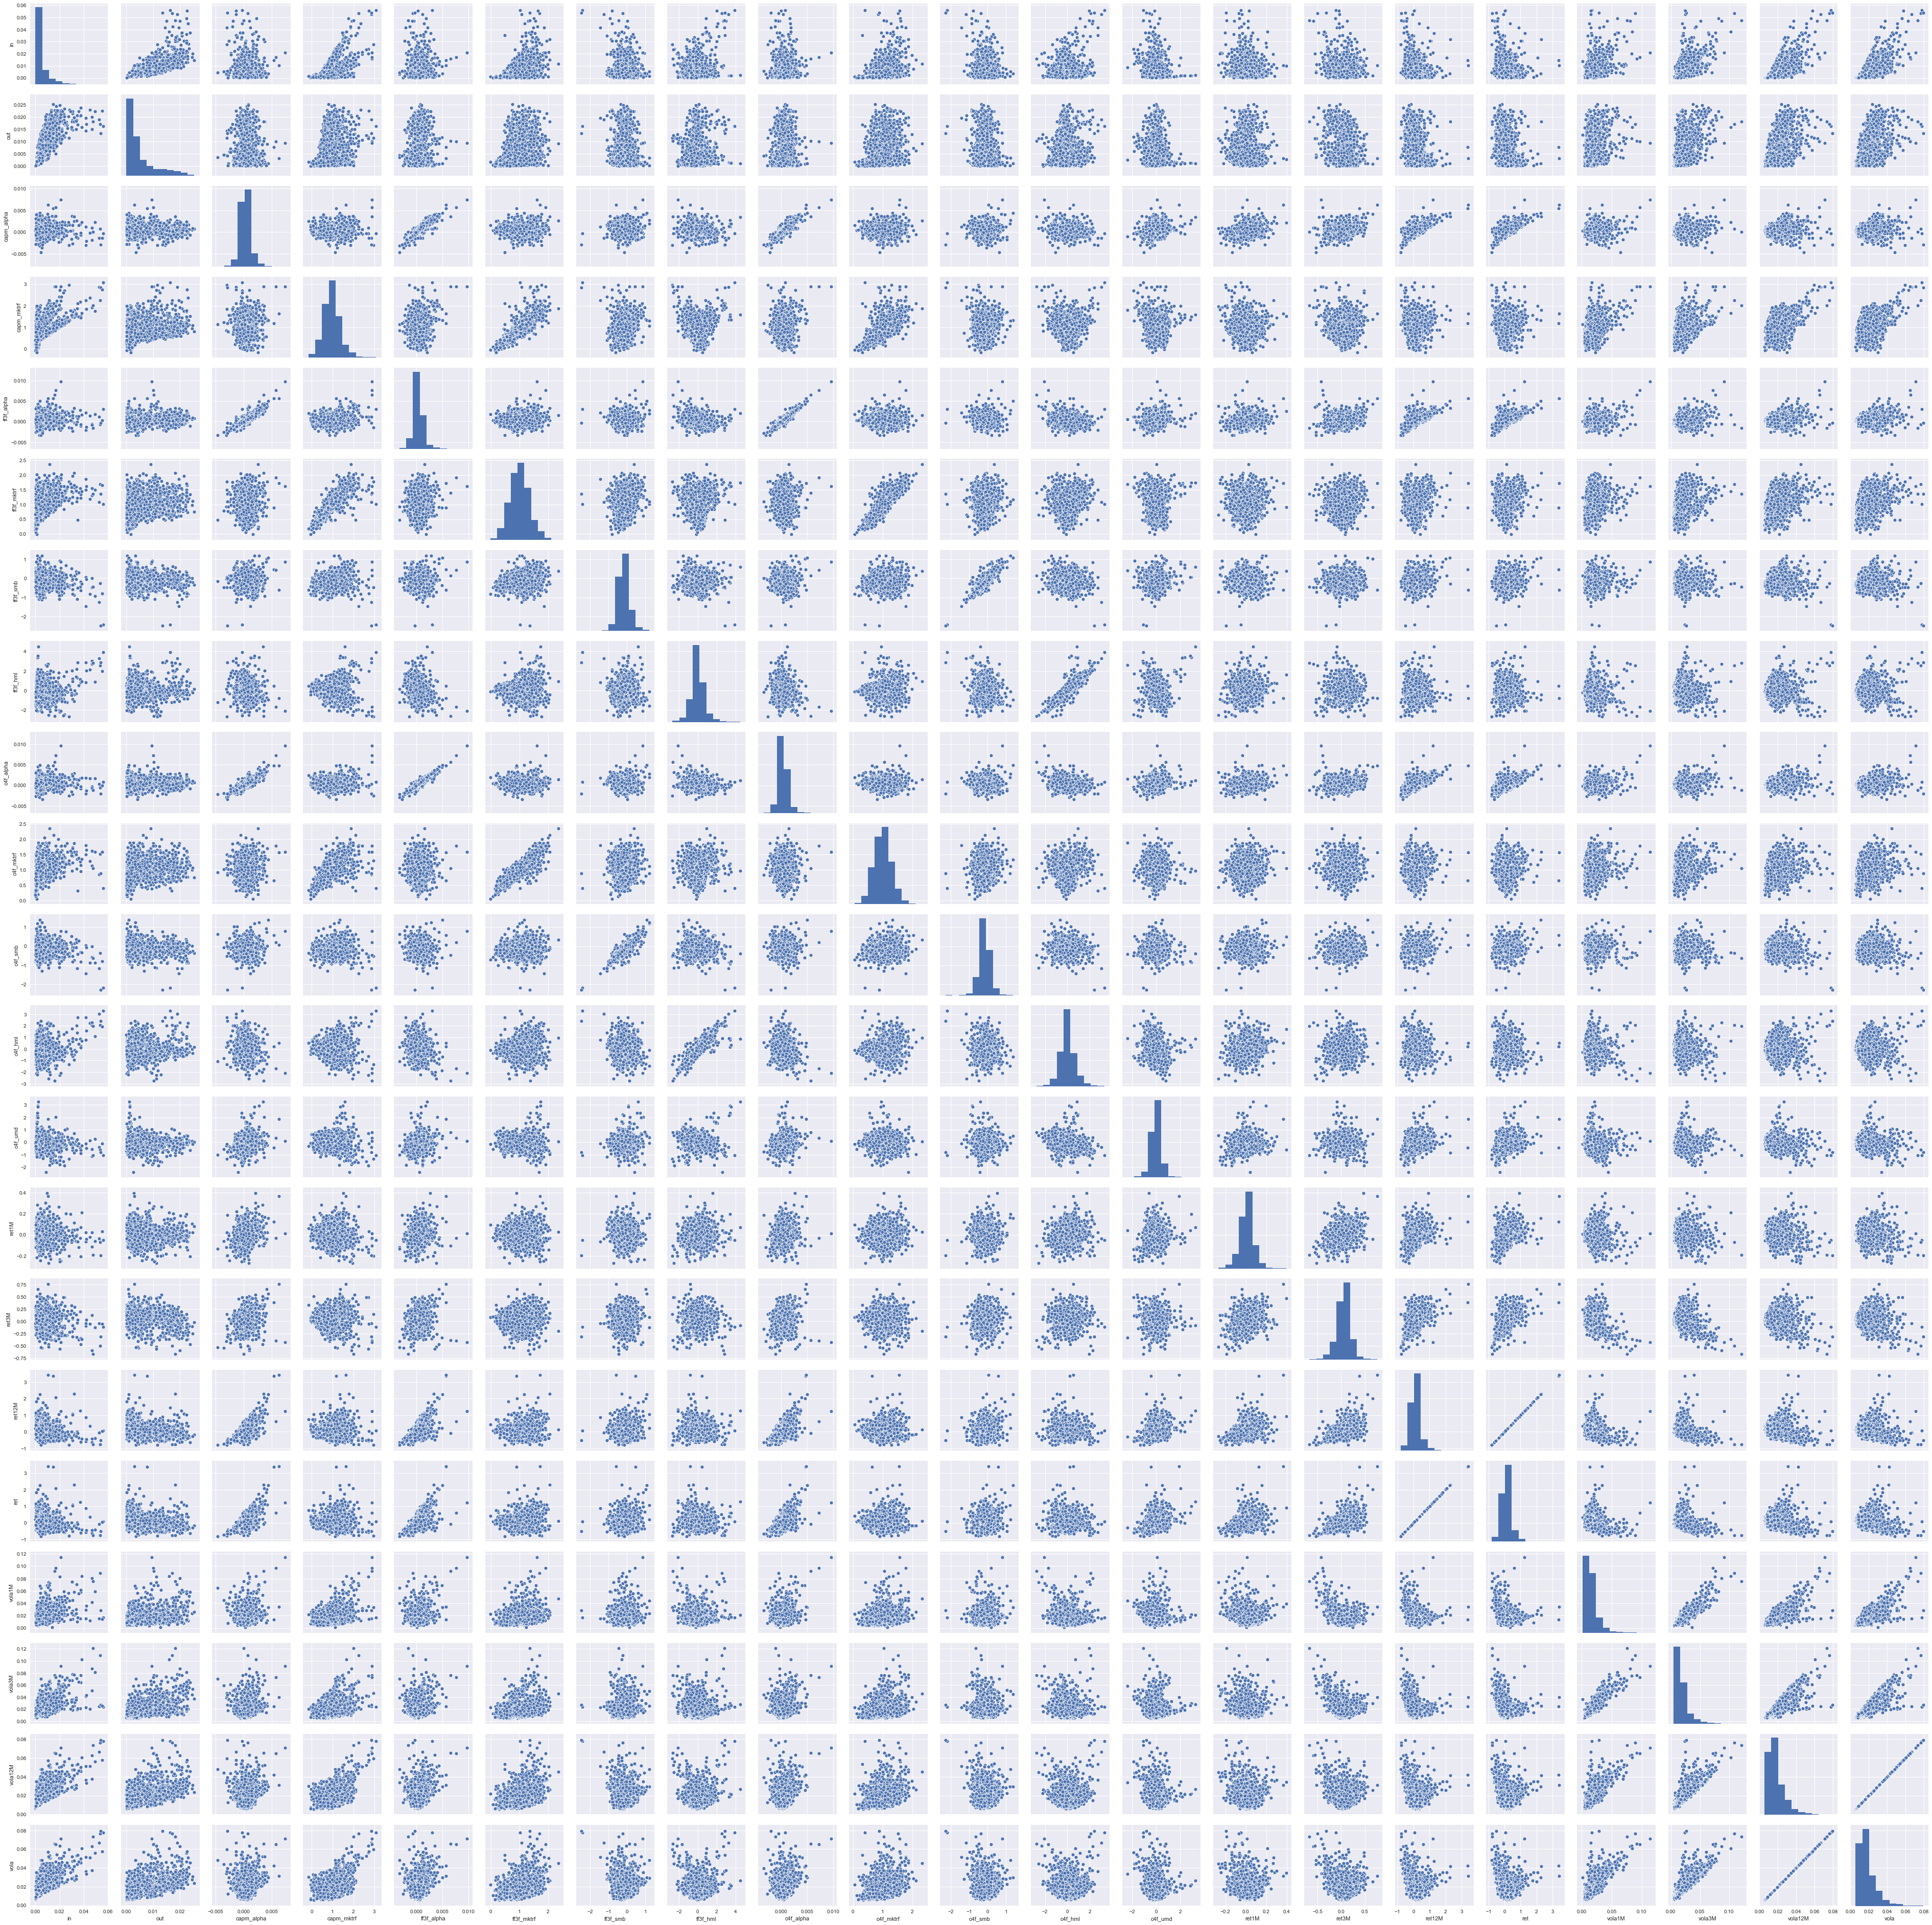

In [20]:
sns.pairplot(df_estimates)
plt.show()